In [1]:
import random,glob,os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from imageio import imread
from skimage import transform,io
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split, ParameterGrid, GridSearchCV
import tensorflow as tf
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model
import warnings 
with warnings.catch_warnings(): 
    warnings.filterwarnings("ignore",category=FutureWarning) 


print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

TensorFlow version: 1.12.0
Keras version: 2.1.6-tf


#     LOAD IMAGES


In [2]:
print ("LOADING IMAGES : START")

samples_path = '/data/CRVI/TEST/MIRALIS/DATA/IMtext_train_test/train/'#os.path.join('../DATA','test_texture')
samples_type = '*.png'


# Parameters ---------------------------------------------------------------------------------
# class_names = ['GOOD', 'DEFECT'] # one classe 
class_names = ['GOOD'] # one classe 
num_class = len(class_names)
batch_size = 64

# Mask ---------------------------------------------------------------------------------

lenx = 56
leny = 56
startx = 84 
starty = 84


#Image generator
def image_generator(batch_size, x_data, y_labels):
    while True:
        batch_input, batch_output = [], []
        for idx in range(len(x_data)):         
            batch_input.append(x_data[idx])
            batch_output.append(y_labels[idx])
            if len(batch_input) >= batch_size:
                yield np.stack(batch_input, axis=0), np.asarray(batch_output)
                batch_input, batch_output = [], []

        # Gestion des batches non complètes
        if len(batch_input) > 0:
            yield np.stack(batch_input, axis=0), np.asarray(batch_output)
            batch_input, batch_output = [], []



x_input, x_mask, masklist = [], [], []
# take images from each classe
for category, ImageDir in enumerate(class_names):
    
    img_paths = glob.glob(os.path.join(samples_path, ImageDir, samples_type))
    
    k = min(2000,len(img_paths))
    
    files = random.sample(img_paths, k )
    print('N images ' + class_names[category] + ': ', k)
    
    for idx, f in enumerate(files):
        try:
            im = np.asarray(imread(f))[:,:,:3].astype('float32') / 255. 
#             plt.imshow(im)
            #print('imagen shape', im.shape)            
        except ValueError:
            print("Could not read", f)
            continue
        im = 2*(im - 0.5)
        # array of images
        x_input.append(transform.resize(im, (224, 224), mode = 'reflect'))
        # create mask 
        imask = np.ones(im.shape)
        
        
        imask[startx:startx+lenx, starty:starty+leny] = 0
        masklist.append(imask)
        
        # image masquée
        ima_mask = im * imask     
        
        x_mask.append(ima_mask)
        # array of outputs
#         y_output.append(to_categorical(category, num_classes=num_class).squeeze())

# combined = list(zip(x_input, y_output))
# random.shuffle(combined)
# x_input[:], y_output[:] = zip(*combined)


# # Split images in train - validation              
x_train, x_val, y_train, y_val = train_test_split(np.stack(x_mask), np.stack(x_input), shuffle=False)


# num_images_train = len(x_train)
# num_images_val = len(x_val)
# print('num images train: ',num_images_train,'num images val: ', num_images_val)


# # Batch generation
train_generator = image_generator(batch_size = batch_size, x_data = x_train, y_labels = y_train)
val_generator = image_generator(batch_size = batch_size, x_data = x_val, y_labels = y_val)



print ("LOADING IMAGES : DONE")

LOADING IMAGES : START
N images GOOD:  2000
LOADING IMAGES : DONE


# PLOT IMAGES

START


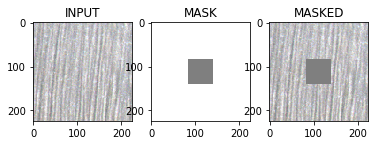

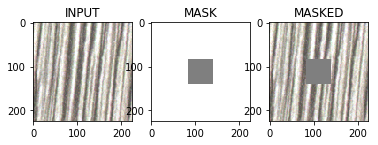

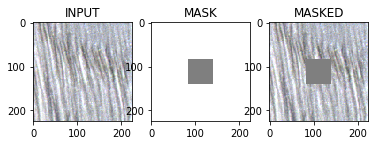

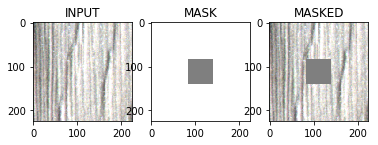

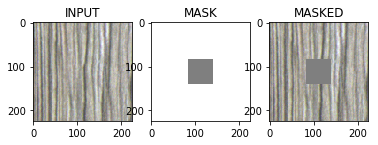

DONE


In [3]:
print ("START")

def do_plot(ax, Z, TI, cmap=None, colors=None):
   
    Z = ((Z/2)+0.5)*255
    
   
    im = ax.imshow((Z).astype(np.uint8),cmap=cmap)
    ax.set_title(TI)
    

nimages = 5;


for i in range(nimages):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    do_plot(ax1,x_input[i],'INPUT')
    do_plot(ax2,masklist[i],'MASK')
    do_plot(ax3,x_mask[i],'MASKED')
    plt.savefig('imasque')
    plt.show()

print ("DONE")

In [4]:
print ("START")

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
print ("DONE")

START
DONE


In [5]:
print ("START")

def get_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
print ("DONE")

START
DONE


In [6]:
print ("START")

im_height=224
im_width=224
print(im.shape)
input_img = Input(im.shape, name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

# model.compile(optimizer=optimizers.Adam(), loss="binary_crossentropy", metrics=["accuracy"])
# model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizers.Adam(lr=0.0001), loss="mean_absolute_percentage_error", metrics=["accuracy"])

model.summary()
print ("DONE")

START
(224, 224, 3)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 16) 0           batch_normalization[0][0]        
_________________________________________________________________________________________

In [7]:
print ("START")

callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ModelCheckpoint('model-mask4.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

print ("DONE")

START
DONE


In [8]:
print ("START")

results = model.fit(x_train, y_train, batch_size=32, epochs=120, callbacks=callbacks, validation_data=(x_val, y_val))
model.save('mask4.h5')

print ("DONE")

START
Train on 1500 samples, validate on 500 samples
Epoch 1/120
1472/1500 [============================>.] - ETA: 0s - loss: 8133.2439 - acc: 0.3766
Epoch 00001: val_loss improved from inf to 8483.72718, saving model to model-mask4.h5
1500/1500 [==============================] - 22s 14ms/step - loss: 8108.2278 - acc: 0.3769 - val_loss: 8483.7272 - val_acc: 0.3454
Epoch 2/120
1472/1500 [============================>.] - ETA: 0s - loss: 5728.0938 - acc: 0.3932
Epoch 00002: val_loss improved from 8483.72718 to 7179.89060, saving model to model-mask4.h5
1500/1500 [==============================] - 9s 6ms/step - loss: 5710.2311 - acc: 0.3933 - val_loss: 7179.8906 - val_acc: 0.4033
Epoch 3/120
1472/1500 [============================>.] - ETA: 0s - loss: 4369.6592 - acc: 0.4131
Epoch 00003: val_loss improved from 7179.89060 to 5648.17247, saving model to model-mask4.h5
1500/1500 [==============================] - 9s 6ms/step - loss: 4361.5490 - acc: 0.4136 - val_loss: 5648.1725 - val_acc: 0.

Epoch 27/120
1472/1500 [============================>.] - ETA: 0s - loss: 1297.4676 - acc: 0.5222
Epoch 00027: val_loss improved from 1264.70380 to 1228.38282, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 1292.5756 - acc: 0.5227 - val_loss: 1228.3828 - val_acc: 0.5280
Epoch 28/120
1472/1500 [============================>.] - ETA: 0s - loss: 1251.2371 - acc: 0.5295
Epoch 00028: val_loss improved from 1228.38282 to 1182.62047, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 1249.5157 - acc: 0.5294 - val_loss: 1182.6205 - val_acc: 0.5368
Epoch 29/120
1472/1500 [============================>.] - ETA: 0s - loss: 1220.1861 - acc: 0.5363
Epoch 00029: val_loss improved from 1182.62047 to 1145.44517, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 1219.0484 - acc: 0.5362 - val_loss: 1145.4452 - val_acc: 0.5469
Epoch 30/120
1472/1500 [================

Epoch 53/120
1472/1500 [============================>.] - ETA: 0s - loss: 848.6743 - acc: 0.6444
Epoch 00053: val_loss improved from 801.97476 to 794.36190, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 850.7101 - acc: 0.6444 - val_loss: 794.3619 - val_acc: 0.6635
Epoch 54/120
1472/1500 [============================>.] - ETA: 0s - loss: 833.5273 - acc: 0.6472
Epoch 00054: val_loss improved from 794.36190 to 783.42688, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 831.9084 - acc: 0.6474 - val_loss: 783.4269 - val_acc: 0.6650
Epoch 55/120
1472/1500 [============================>.] - ETA: 0s - loss: 836.9379 - acc: 0.6479
Epoch 00055: val_loss did not improve from 783.42688
1500/1500 [==============================] - 7s 5ms/step - loss: 833.6121 - acc: 0.6482 - val_loss: 791.8035 - val_acc: 0.6661
Epoch 56/120
1472/1500 [============================>.] - ETA: 0s - loss: 829.3232 - acc: 0.6

Epoch 80/120
1472/1500 [============================>.] - ETA: 0s - loss: 724.5998 - acc: 0.6766
Epoch 00080: val_loss improved from 698.65161 to 698.15076, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 721.6637 - acc: 0.6765 - val_loss: 698.1508 - val_acc: 0.6931
Epoch 81/120
1472/1500 [============================>.] - ETA: 0s - loss: 720.6780 - acc: 0.6776
Epoch 00081: val_loss improved from 698.15076 to 692.46853, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 719.4619 - acc: 0.6778 - val_loss: 692.4685 - val_acc: 0.6919
Epoch 82/120
1472/1500 [============================>.] - ETA: 0s - loss: 719.0979 - acc: 0.6785
Epoch 00082: val_loss did not improve from 692.46853
1500/1500 [==============================] - 7s 5ms/step - loss: 716.2090 - acc: 0.6782 - val_loss: 693.9675 - val_acc: 0.6940
Epoch 83/120
1472/1500 [============================>.] - ETA: 0s - loss: 721.5063 - acc: 0.6

Epoch 108/120
1472/1500 [============================>.] - ETA: 0s - loss: 661.3049 - acc: 0.7021
Epoch 00108: val_loss improved from 649.38559 to 644.69334, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 660.5239 - acc: 0.7021 - val_loss: 644.6933 - val_acc: 0.7174
Epoch 109/120
1472/1500 [============================>.] - ETA: 0s - loss: 666.9237 - acc: 0.7020
Epoch 00109: val_loss did not improve from 644.69334
1500/1500 [==============================] - 7s 5ms/step - loss: 667.9131 - acc: 0.7022 - val_loss: 648.5987 - val_acc: 0.7173
Epoch 110/120
1472/1500 [============================>.] - ETA: 0s - loss: 665.3045 - acc: 0.7030
Epoch 00110: val_loss improved from 644.69334 to 644.55543, saving model to model-mask4.h5
1500/1500 [==============================] - 7s 5ms/step - loss: 663.4324 - acc: 0.7032 - val_loss: 644.5554 - val_acc: 0.7143
Epoch 111/120
1472/1500 [============================>.] - ETA: 0s - loss: 659.0296 - acc:

In [9]:
print ("START")
# Load best model
model.load_weights('model-mask4.h5')

print ("DONE")

START
DONE


In [10]:
print ("START")
# Evaluate on validation set (this must be equals to the best log_loss)
print(model.metrics_names)

eval_train = model.evaluate(x_train, y_train, verbose=1)
eval_val = model.evaluate(x_val, y_val, verbose=1)

print('Train {} {} {} {}'.format(model.metrics_names[0],eval_train[0],model.metrics_names[1],eval_train[1]))
print('Validation {} {} {} {}'.format(model.metrics_names[0],eval_val[0],model.metrics_names[1],eval_val[1]))

print ("DONE")

START
['loss', 'acc']
500/500 [==============================] - 1s 2ms/step
Train loss 612.3923068033854 acc 0.7260339471499125
Validation loss 633.0887243652344 acc 0.725574342250824
DONE


In [11]:
print ("START")
# Predict on train, val and test
preds_train = model.predict(x_train, verbose=1)
preds_val = model.predict(x_val, verbose=1)
# print(preds_val[1])

# Threshold predictions
preds_train_t = (preds_train - x_train)
preds_val_t = (preds_val - x_val)

print ("DONE")

START
500/500 [==============================] - 1s 1ms/step
DONE


START


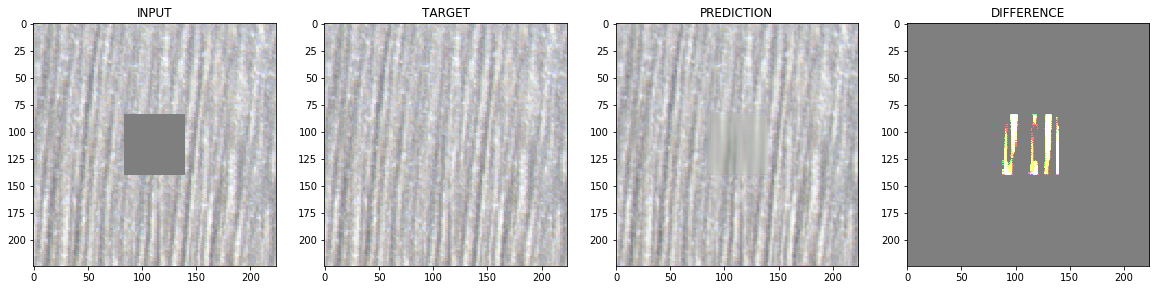

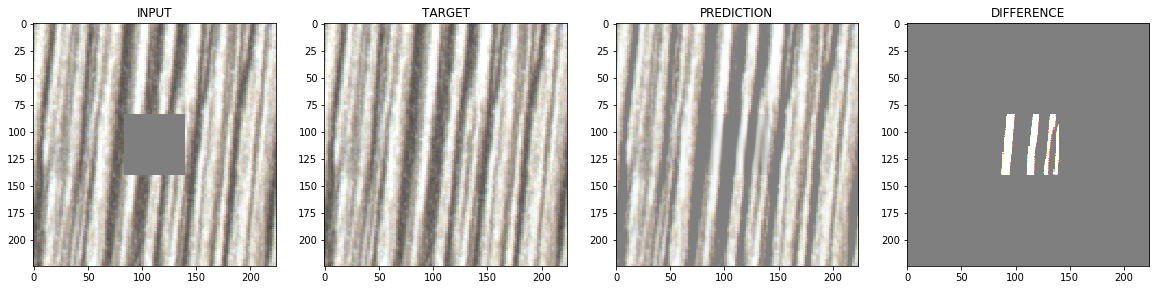

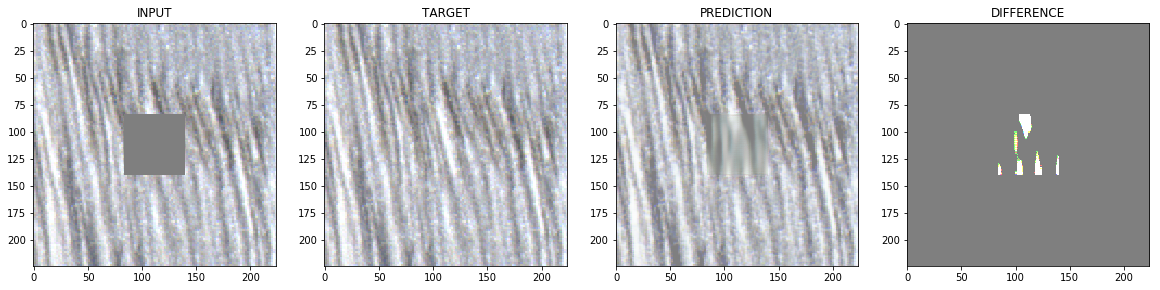

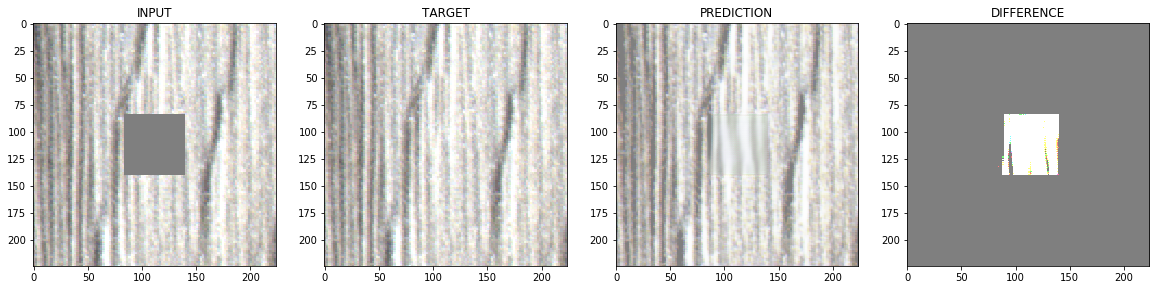

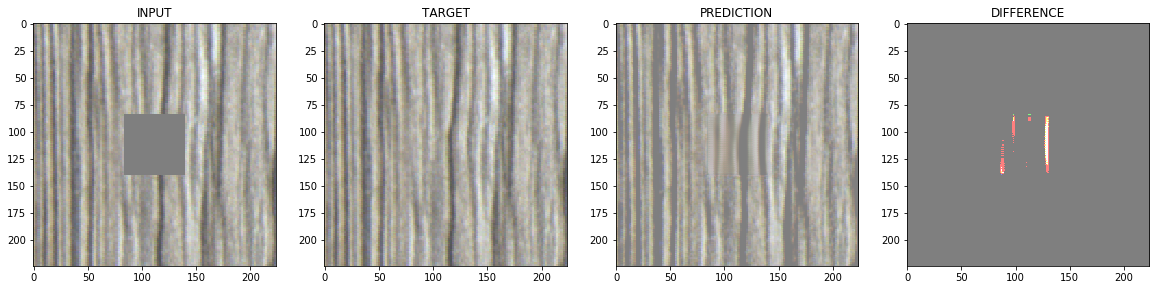

DONE


In [12]:
print ("START")

from matplotlib import cm


for i in range(5):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20, 10))
    do_plot(ax1,x_train[i],'INPUT')
    do_plot(ax2,y_train[i],'TARGET')
    do_plot(ax3,preds_train[i],'PREDICTION')
        
    # Threshold predictions
    preds_threshold = (preds_train_t[i] > 0.5).astype(np.uint8)
    


    do_plot(ax4,preds_threshold,'DIFFERENCE')
#     plt.savefig('imasque')
    plt.show()
    
    
    
print ("DONE")